# **Assignment 2:** Group 25

Yuval Rossen (S5322197)

Nick Huisman (S5378117)

Mark Prirodins (S4763939)

Cata Mihit (S4737849)

# **1. Playing Golf**

In [ ]:
# the necessary packages (matplotlib.pyplot and numpy) are imported.
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Defining the motion
### Equation derivation

**Drag Force:** The Drag force $\vec{F}_D$ acts on the ball in the same direction as the ball's speed and opposing its motion. Its expression is:
$$ \vec{F}_D = -\alpha_D |\vec{v}| \vec{v} .$$
Here, $\vec{v}$ is the ball's speed and $\alpha_D$ is a proportionality factor given by:
$$\displaystyle\alpha_D = \frac{1}{2}\rho A C_D .$$
The constant $C_D$ is the Drag coefficient.
The expression for the Drag force can be rewritten as $\displaystyle \vec{F}_D = -\frac{1}{2}\rho A C_D |\vec{v}| \vec{v}$.

**Lift Force:** The Lift force $\vec{F}_L$ acts on the ball in a direction *perpendicular* to the ball's speed. Its expression is similar to the Drag force, with a proportionality constant $\alpha_L$:
$$ \vec{F}_L = -\alpha_L |\vec{v}| \vec{u} .$$
Here, $\vec{u}$ is the vector orthogonal to $\vec{v}$ and with the same magnitude, $|\vec{u}| = |\vec{v}|$, such that $\vec{F}_L$ is also proportional to the square of the velocity. The constant $\alpha_L$ can be expressed in the same way as $\alpha_D$, only with a $C_L$ Lift coefficient instead.

**Gravity:** Aside from Drag and Lift, the ball is also affected by the gravitational force $\vec{F}_g = m \vec{g}$, with assumed constant downwards acceleration $g$.

**Second Law:** $\displaystyle \vec{F}_D + \vec{F}_L + \vec{F}_g = m\vec{a} \;\Longrightarrow\; \vec{a} = -\frac{1}{2m}\rho A C_D |\vec{v}|\vec{v} - \frac{1}{2m}\rho A C_L |\vec{v}|\vec{u} + \vec{g}.$

**Vector Representation:**
The velocity can be written in vector form as $\displaystyle \vec{v} = \begin{pmatrix} v_x \\ v_y \end{pmatrix}$, the acceleration as $\displaystyle \vec{a} = \begin{pmatrix} a_x \\ a_y \end{pmatrix}$, and the (constant downwards) gravitational acceleration as $\displaystyle \vec{g} = \begin{pmatrix} 0 \\ -g \end{pmatrix}$.

Since the vector $\vec{u}$ is the same as $\vec{v}$ rotated by 90 degrees, we have $\displaystyle \vec{u} = \begin{pmatrix} v_y \\ -v_x \end{pmatrix}$. A clockwise rotation was chosen because that is how the Lift force acts on the motion of objects with backspin.

Replacing these values and splitting the single vector equation by components, we get:
$$
a_x = - \frac{\rho A}{2 m} C_D |\vec{v}| v_x - \frac{\rho A}{2 m} C_L |\vec{v}| v_y
$$
$$
a_y = - \frac{\rho A}{2 m} C_D |\vec{v}| v_y + \frac{\rho A}{2 m} C_L |\vec{v}| v_x - g
$$

**Derivative Notation:**
For some position vector $\displaystyle \vec{r} = \begin{pmatrix} r_x \\ r_y \end{pmatrix}$, we have $\displaystyle \vec{v} = \dot{\vec{r}} \;\Longrightarrow\; \begin{pmatrix} v_x \\ v_y \end{pmatrix} = \begin{pmatrix} \dot{r}_x \\ \dot{r}_x \end{pmatrix}$, and $\displaystyle \vec{a} = \ddot{\vec{r}} \;\Longrightarrow\; \begin{pmatrix} a_x \\ a_y \end{pmatrix} = \begin{pmatrix} \ddot{r}_x \\ \ddot{r}_x \end{pmatrix}$. This allows us to create a system of 2nd order ODEs:

$\displaystyle \frac{d^2 r_x}{dt^2} = - \frac{\rho A}{2 m} C_D |\vec{v}| \frac{d r_x}{dt} - \frac{\rho A}{2 m} C_L |\vec{v}| \frac{d r_y}{dt} $

$\displaystyle \frac{d^2 r_y}{dt^2} = + \frac{\rho A}{2 m} C_L |\vec{v}| \frac{d r_x}{dt} - \frac{\rho A}{2 m} C_D |\vec{v}| \frac{d r_y}{dt} - g $

### Program constants

In [ ]:
# Define constants:
m = 0.05            # mass of the ball in kg
r = 0.02            # radius of the ball in m
g = 9.80665         # acceleration due to gravity in m/s^2
rho = 1.204         # air density at 1 atmosphere & 20°C in kg/m^3.
dt = 0.001          # time step in seconds
A = np.pi * r**2    # Cross-sectional area of the ball (assuming it's a sphere)

### Equation implementation

The derivation above expresses the acceleration in terms of speed. We can use `odeint` to solve the system, and this requires a function that takes in a vector containing positions and velocities and returns the velocities and new accelerations.

In [ ]:
def derivatives(vec, t, C_D, C_L):
    rx, ry, drx_dt, dry_dt = vec           # vec contains [x, y, vx, vy]

    v = np.sqrt(drx_dt**2 + dry_dt**2)     # compute velocity

    K = (rho * A) / (2 * m)                # more readable in expressions

    # Definition of d2r/dt2 in terms of dr/dt
    d2rx_dt2 = - K * C_D * v * drx_dt - K * C_L * v * dry_dt
    d2ry_dt2 =   K * C_L * v * drx_dt - K * C_D * v * dry_dt - g

    return (drx_dt, dry_dt, d2rx_dt2, d2ry_dt2)

## Solving the Equations

The `motion_solver` function takes in the arguments:
- `theta`: the given angle of the ball's initial speed with the horizontal
- `t`: a time series
- `C_D`: the drag coefficient $C_D$ with the default value of 0.3
- `C_L`: the drag coefficient $C_L$ with the default value of 0.3

It returns a series of $x$ and $y$ values - one pair for each time value in `t` - representing the ball's position over time. These are truncated, so that the trajectory is discarded after the ball reaches the ground again.

### Initial conditions
The ball is thrown from the origin $\vec{r}_0 = (0,0)$ with a speed of $|\vec{v}_0| = 60$ m/s at an arbitrary angle $\theta$ from the horizontal. This results in a vector $\vec{v}_0 = 60\left(\cos(\theta), \sin(\theta)\right)$, where $\theta$ is specified in radians (our code uses $\theta$ in degrees until the conversion in this function). Thus, the `initial_conditions` vector is formatted according to the requirements of the `odeint` solver, which requires both the position and the speed to be specified.

In [ ]:
def motion_solver(theta, t, C_D = 0.3, C_L = 0.3):
    # Initial conditions
    r0 = [0, 0]
    v0 = 60
    initial_conditions = [r0[0], r0[1], v0 * np.cos(np.radians(theta)), v0 * np.sin(np.radians(theta))]

    # Use odeint to integrate the equations of motion:
    result = odeint(derivatives, initial_conditions, t, args=(C_D, C_L))

    # Find the index 'n' where 'y' becomes negative or zero:
    n = 0
    for i in result[:, 1]:
        if i >= 0:
            n += 1
        else:
            break

    # Extract position data from the 'result' variable (trajectory):
    x = result[:n, 0]
    y = result[:n, 1]

    return x, y

## Plotting the motion
### A. Motion of Ball at a Given Angle

The function `plot_motion` takes in the arguments:
- `t`: a time series
- `theta`: the given angle of the ball's initial speed with the horizontal
- `C_D`: the drag coefficient $C_D$ with the default value of 0.3
- `C_L`: the drag coefficient $C_L$ with the default value of 0.3

The time series and angle as passed into the differential equation solver from above, returning the coordinates $x_i$ and $y_i$ of the ball at each time in `t`, which are plotted.

The rest of the function handles the layout and appearence of the figure.

In [ ]:
def plot_motion(t, theta, C_D = 0.3, C_L = 0.3):
    # Create a figure
    plt.figure()

    # Determine and plot trajectory at angle theta
    x, y = motion_solver(theta, t, C_D, C_L)
    plt.plot(x, y, label = f"$C_D = {C_D}, C_L = {C_L}, \\theta = {theta}^\circ$")

    # Set plot axis limits
    plt.xlim([np.min(x) - 5, np.max(x) + 5])
    plt.ylim([0, np.max(y) + 5])

    # Set plot axis labels
    plt.xlabel("Horizontal Distance (m)")
    plt.ylabel("Vertical Distance (m)")

    # Set plot title
    title = "Trajectory of Ball "
    title += "with Drag " if C_D != 0 else "without Drag "
    title += "and "
    title += "with Lift" if C_L != 0 else "without Lift"
    plt.title(title)

    # Show plot legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Show plot
    plt.show()

### Examples

Below the plotting function is used to create the plots for the trajectory of the ball when thrown at an angle of $\theta = 45^{\circ}$, in three separate cases:
- No drag and no Lift
- Drag and no Lift
- Drag and Lift

As implemented in the solver, the trajectory gets cut off once the ball reaches the ground again. The values use for the Drag and Lift coefficients are both 0.3. In the function calls they were not ommitted, although that is also possible given their default values in the function definition.

Initial launch angle (degrees), θ = 45


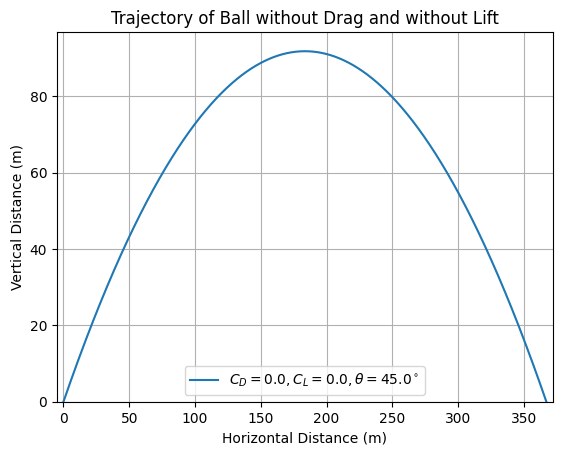

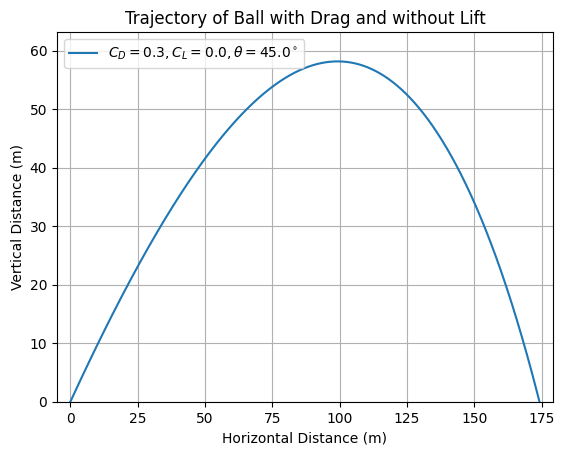

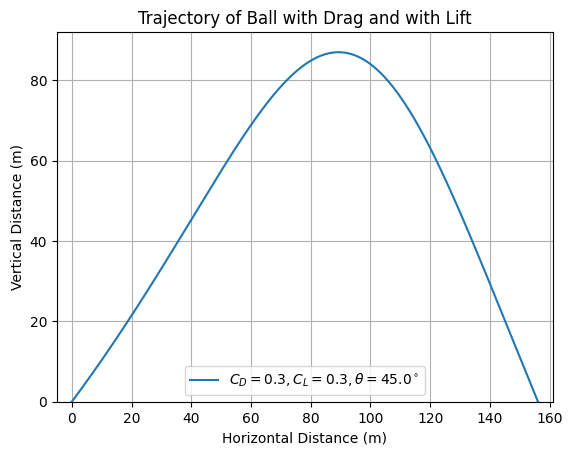

In [ ]:
t = np.arange(0, 30, dt)
theta = float(input("Initial launch angle (degrees), θ = "))

plot_motion(t, theta, C_D = 0.0, C_L = 0.0)
plot_motion(t, theta, C_D = 0.3, C_L = 0.0)
plot_motion(t, theta, C_D = 0.3, C_L = 0.3)
# without Drag and with Lift is also possible

#### Discussion (for $\theta=75^\circ$)

The three plots showcase the trajectory of the ball for different drag and lift coefficients.
- The first case corresponds to regular projectile motion, as expected, as the only force acting on the ball is gravity.
- In the second case, the drag force acts against the motion of the ball, decelerating it, which results in a much faster return to the ground. Not only is the distance travelled much smaller, the maximum height that the ball reaches is also significantly lower.
- The third case represents the combined action of drag and lift. The trajectory can be explained by the Drag and Lift forces, which accelerate the ball first against the direction of its regular motion (Drag), then perpendicular to its regular motion (Lift). For an angle as large as $\theta=75^\circ$, this makes the ball go backwards and create a loop.

### B. Motion of Ball at a series of angles

The function `plot_motion_series` takes in the arguments:
- `t`: a time series
- `theta_bounds`:
- `C_D`: the drag coefficient $C_D$ with the default value of 0.3
- `C_L`: the drag coefficient $C_L$ with the default value of 0.3
- `colormap_name`:

The time series and angle as passed into the differential equation solver from above, returning the coordinates $x_i$ and $y_i$ of the ball at each time in `t`, which are plotted.

The rest of the code handles the layout and appearence of the figure.

In [ ]:
# Import more necessary packages
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [ ]:
def plot_motion_series(t, theta_bounds, C_D = 0.3, C_L = 0.3, colormap_name = "viridis"):
    # Create a figure
    plt.figure()

    # Define what theta values will be used along with the colormap of the figure
    theta_min, theta_max, theta_step = theta_bounds
    theta_values = np.arange(theta_min, theta_max, theta_step)
    normalize = mcolors.Normalize(vmin = theta_values[0], vmax = theta_values[-1])
    colormap = plt.get_cmap(colormap_name)

    xmin = 0
    xmax = 0
    ymax = 0

    # Determine and plot trajectory at each angle theta
    for theta in theta_values:
        x, y = motion_solver(theta, t, C_D, C_L)
        xmin = np.min(x) if np.min(x) < xmin else xmin
        xmax = np.max(x) if np.max(x) > xmax else xmax
        ymax = np.max(y) if np.max(y) > ymax else ymax
        plt.plot(x, y, color = colormap(normalize(theta)))

    # Set plot axis limits
    plt.xlim([xmin - 5, xmax + 5])
    plt.ylim([0, ymax + 5])

    # Set plot axis labels
    plt.xlabel("Horizontal Distance (m)")
    plt.ylabel("Vertical Distance (m)")

    # Set plot title
    title = "Trajectory of Ball "
    title += "with Drag " if C_D != 0 else "without Drag "
    title += "and "
    title += "with Lift" if C_L != 0 else "without Lift"
    plt.title(title)

    # Show color bar
    scalarmappaple = cm.ScalarMappable(norm = normalize, cmap = colormap)
    scalarmappaple.set_array(theta_values)
    plt.colorbar(scalarmappaple, ax = plt.gca(), ticks = [theta for theta in theta_values]).ax.set_xlabel("$\\theta(°)$")

    # Show grid
    plt.grid(True)

    # Show plot
    plt.show()

### Examples

The extended plotting function is used to create the plots for the trajectories of the ball at a series of different angles in the same way described in A. The cases are:
- No drag and no Lift
- Drag and no Lift
- Drag and Lift

In addition to Part A, theta_bounds needs to be specified. The colormap was changed between plots for fun :)

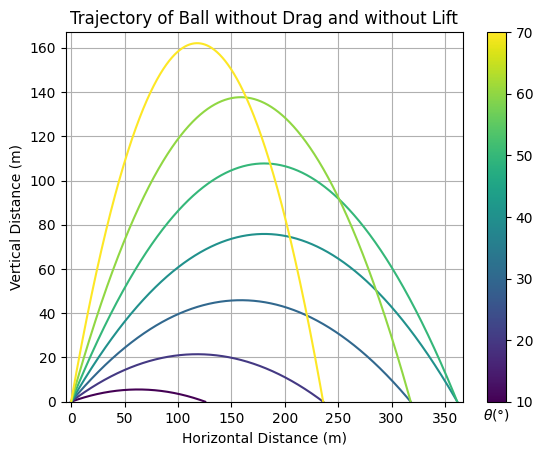

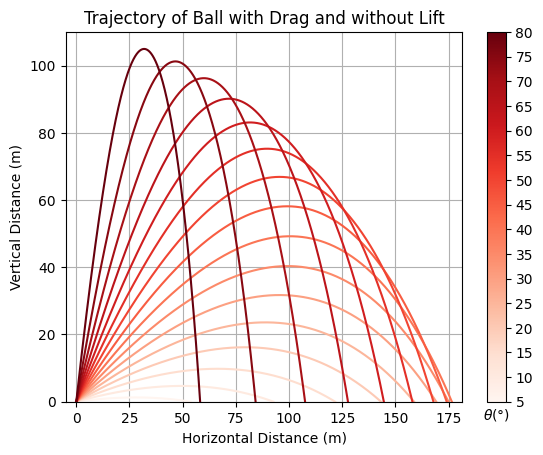

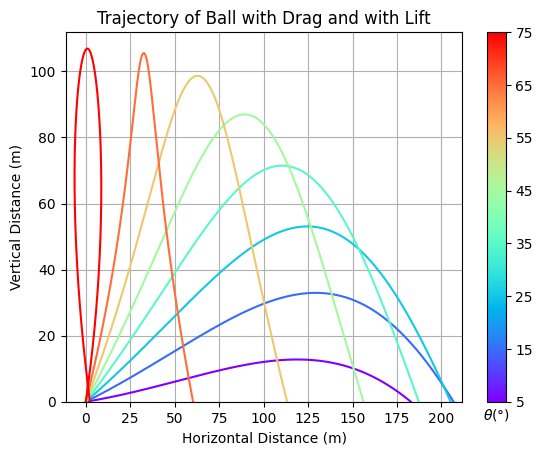

In [ ]:
plot_motion_series(t, theta_bounds = [10, 80, 10], C_D = 0.0, C_L = 0.0)
plot_motion_series(t, theta_bounds = [ 5, 85,  5], C_D = 0.3, C_L = 0.0, colormap_name = "Reds")
plot_motion_series(t, theta_bounds = [ 5, 85, 10], C_D = 0.3, C_L = 0.3, colormap_name = "rainbow")
# without Drag and with Lift is also possible

#### Discussion

Above are showcased the trajectories of the ball at different angles and different drag and lift coefficients. This showcases the accuracy of the numerical differential equation solver to be quite high, as the motion closely follows both intuition about the action of forces on the object, as well as the analytical expression of the object's motion.

These graphs also showcase the large difference in distances travelled for different angles of $\theta$, which is explored in more depth in the following subsection.

## Optimal Launch Angles

### Determining the angles

The function `maximums` loops through all angles $\theta$ between 0.1 and 89.9 degrees, computing the trajectory of the ball for specified drag and lift coefficients. The arrays of values are returned together with the coefficients.

In [ ]:
def maximums(t, C_D = 0.3, C_L = 0.3):
    distances = []
    angle_range = np.arange(0.1, 90, 0.1)  # Angle range from 1 to 89.9 degrees in 0.1 degree increments

    for theta in angle_range:
        # Calculate trajectory for each launch angle
        x, y = motion_solver(theta, t, C_D, C_L)

        distance = 0
        for height in y:
            if height < 0:
                break
            distance += 1

        x_motion = x[:distance]
        total_distance_ = x_motion[-1]
        distances.append(total_distance_)

    return [angle_range, distances, C_D, C_L]

### Plotting the results

The function `plot_maximums` takes in the return data of `maximums` and uses it to create a plot of the distance travelled by the ball ($y$-axis) for each of the angles ($x$-axis). It also points out the optimal launch angle and what maximum distance it results in.

In [ ]:
def plot_maximums(data):
    angle_range = data[0]
    distances = data[1]
    C_D = data[2]
    C_L = data[3]

    # Find the optimal angle for maximum displacement
    optimal_angle_index = distances.index(max(distances))
    optimal_angle = angle_range[optimal_angle_index]+0.1

    # Create plot of distance against angle
    plt.figure()

    # Plot elements
    plt.plot(angle_range, distances)                                                        # Plot graph itself
    plt.axhline(y = 0, color = 'r', linestyle = '-', linewidth=1)                           # Indicator line for distance = 0
    plt.axvline(x = optimal_angle, color = 'g', linestyle = '--', linewidth=1.5)            # Indicator line for optimal angle
    plt.axhline(y = max(distances), color = 'g', linestyle = '--', linewidth=1.5)           # Indicator line for maximum distance
    plt.plot([optimal_angle], [max(distances)], marker = 'x', markersize = 10, color = 'g') # Point at maximum

    # Set plot axis limits
    plt.xlim([0, angle_range[-1]])
    plt.ylim([np.min(distances), np.max(distances) + 20])

    # Set plot axis labels
    plt.xlabel("$\\theta$ (degrees)")
    plt.ylabel("Horizontal Distance (m)")

    # Set plot title
    title = "Distance at different $\\theta$ "
    title += "with Drag " if C_D != 0 else "without Drag "
    title += "and "
    title += "with Lift" if C_L != 0 else "without Lift"
    plt.title(title)

    # Show grid
    plt.grid(True)

    # Show plot
    plt.show()

    # Print exact values
    print(f"Optimal Launch Angle for Maximum Displacement: {round(optimal_angle, 2)} degrees")
    print(f"Maximum Displacement: {round(max(distances), 6)} meters\n")

### Examples

The code below plots the distance travelled against the angle for different drag and lift coefficients.

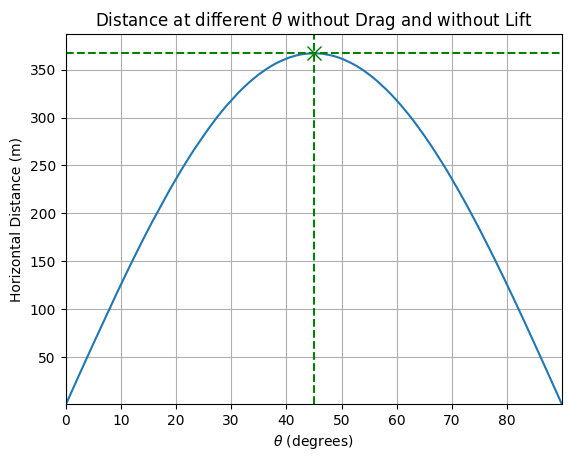

Optimal Launch Angle for Maximum Displacement: 45.0 degrees
Maximum Displacement: 367.075871 meters



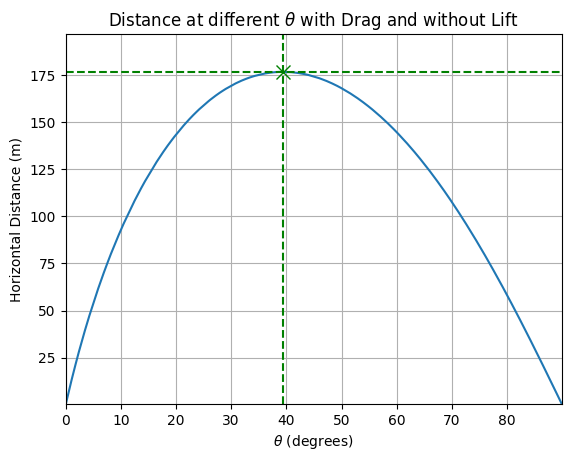

Optimal Launch Angle for Maximum Displacement: 39.4 degrees
Maximum Displacement: 176.590439 meters



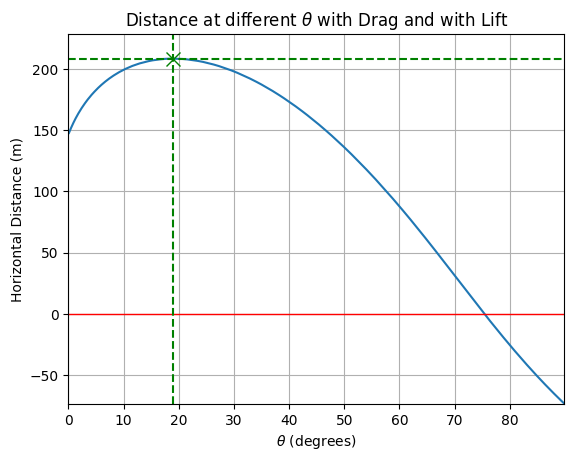

Optimal Launch Angle for Maximum Displacement: 18.9 degrees
Maximum Displacement: 208.402392 meters



In [ ]:
plot_maximums(maximums(t, C_D = 0.0, C_L = 0.0))
plot_maximums(maximums(t, C_D = 0.3, C_L = 0.0))
plot_maximums(maximums(t, C_D = 0.3, C_L = 0.3))

#### Discussion

These figures only show a different perspective on the motion parameters than in the subsection above where several trajectories are plotted simultaneously, with focus on the precise values of $\theta$ and the maximum (positive) horizontal displacement it defines. These plots also follow both intuition and the equations of motion, as the distance travelled naturally grows with the angle before the launch is too close to the horizontal and the motion reaches a greater height rather than distance.

# **2. Piezo-Electro Sensor**


In [ ]:
# Import necessary libraries (if not already imported for Part 1)
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Defining the variables:
- $m$ = Mass of the oscillator (in kg)
- $x(t)$ = Displacement from the equilibrium position (in m)
- $\lambda$ = Damping coefficient
- $k$ = Spring constant
- $F(t)$ = Applied force
- $\alpha$ = Charge sensitivity (zero in this question)
- $\omega_n$ = Undamped natural frequency $\displaystyle\left(\omega_n = \sqrt\frac{k}{m}\right)$
- $\xi$ = Damping ratio $\displaystyle\left(\xi = \frac{\lambda}{2\sqrt(km)}\right)$

Enter ω_n(enter 1): 1
Enter ξ(enter 0.3): 0.3
Enter α(enter 0): 0
Enter ω(enter 1): 1


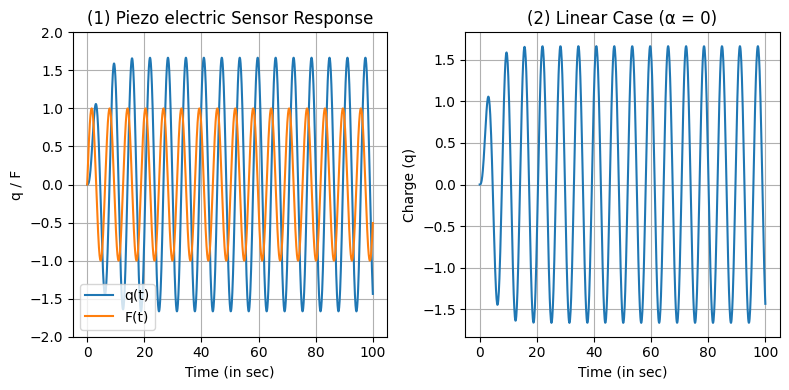

In [ ]:
# Define a function that defines the differential equation for the first case
def differential_equation(q, t, ω_n, ξ, α, ω):
    q1, q2 = q  # q1 = q, q2 = q'
    q1_dot = q2
    q2_dot = (1/ω_n**2) * (-2*ξ*q2 - q1 - α*q1**3 + np.sin(ω*t))
    return [q1_dot, q2_dot]

# Get user inputs for ω_n, ξ, α, and ω
ω_n = float(input("Enter ω_n(enter 1): ")) # Natural frequency of the circuit
ξ = float(input("Enter ξ(enter 0.3): ")) # Damping coefficient
α = float(input("Enter α(enter 0): ")) # Non-linearity parameter
ω = float(input("Enter ω(enter 1): "))  # External frequency

# Impose some initial conditions
q0 = [0.0, 0.0]  # Initial values for q and q'

# Time points for the solution
t = np.linspace(0, 100, 10000)  # Adjust the time range as needed

# Solve the differential equation using odeint
solution = odeint(differential_equation, q0, t, args=(ω_n, ξ, α, ω))

# Extract q values from the solution
q = solution[:, 0]

# Calculate F(t) = sin(ωt)
F = np.sin(ω * t)

# Create a mask for t > 50
mask = t > 50

# Set smaller figure dimensions
plt.figure(figsize=(8, 4))

# Plot q(t) and F(t) on the same graph with legends
plt.subplot(1, 2, 1)
plt.plot(t, q, label='q(t)')
plt.plot(t, F, label='F(t)')
plt.xlabel('Time (in sec)')
plt.ylabel('q / F')
plt.title('(1) Piezo electric Sensor Response')
plt.legend()
plt.grid(True)
plt.ylim(-2, 2)  # Set y-axis limits

# Constants for the second case
omegan = 1.0  # Natural frequency
xi = 0.3    # Damping factor
alpha = 0  # Non-linearity parameter
A = 1.0      # Amplitude of the input force
t_max = 100  # Maximum simulation time

# Linear differential equation (alpha = 0)
def linear_diffeq(t, y):
    q, q_dot = y
    q_ddot = -2.0 * xi * omegan * q_dot - omegan**2 * q + A * np.sin(ω * t)
    return [q_dot, q_ddot]

# Solve the differential equations for the second case
sol_linear = solve_ivp(linear_diffeq, [0, t_max], [0, 0], t_eval=np.linspace(0, t_max, 1000))

# Extract charge (q) values for the linear case
q_linear = sol_linear.y[0]

# Plot linear case (alpha = 0)
plt.subplot(1, 2, 2)
plt.plot(sol_linear.t, q_linear)
plt.xlabel('Time (in sec)')
plt.ylabel('Charge (q)')
plt.title('(2) Linear Case (α = 0)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ! Resonant frequency & a pure harmonic can be observed by providing the following values:
# For ω_n = 1
# For ξ = 0.3
# For α = 0
# For ω = 1
# With ω = ω_n (=1), the two frequencies are equal, hence resonance behavior occurs.

#Note: The user input values only affect graph (1). To adjust graph (2), change lines 52 - 56.

In graph 1 we see that,
 <br>
(for $ \omega_n = 1$,   $\xi = 0.3$ $\alpha = 0$ and $\omega = 1$)
 <br>

 if $ \omega_n$(natural) == $ \omega$(external) we get the largest value --> resonance!. Furthermore, one can observe that there is a slight difference between the phase of the force and the charge. --> the charge is slightly in front of the force.

In graph 2 we see that around 20 seconds the charge q(t) behaves like a stable harmonic function.


Angular frequency of q(t): 1.01 rad/s


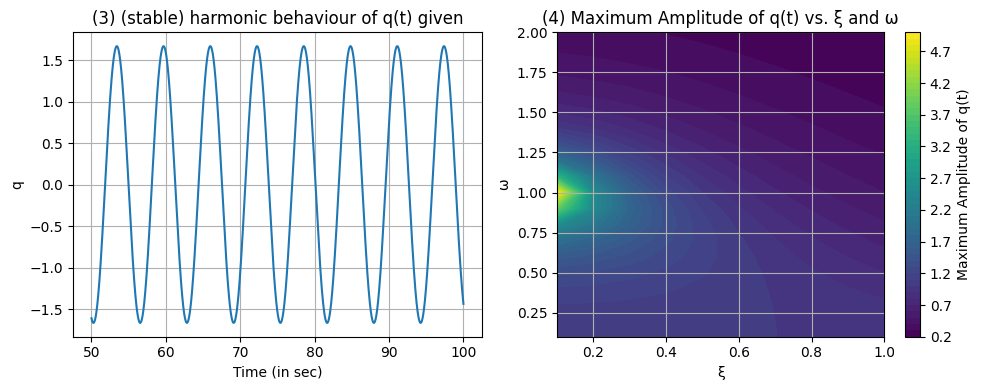

Resonant behavior observed.
Resonance occurs at ω = 1.01, close to the natural frequency ω_n = 1.0.


In [ ]:
# For good measure implement the packages again
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Now let's perform Fourier analysis (FA) on q(t) to find the angular frequency (omega'), this provides insight in the stability of the function --> how good is our harmonic?
def find_angular_frequency(signal, time):
    # Actually performing the Fourier Transform
    spectrum = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(time), time[1] - time[0])

    # Find index corresponding to max amplitude in the spectrum by using the np.argmax function.
    max_index = np.argmax(np.abs(spectrum))

    # Then extract angular frequency corresponding to the maximum amplitude by calling it's 'place'.
    omega_prime = 2 * np.pi * np.abs(freqs[max_index])
    return omega_prime

# perform FA on q(t)
omega_prime = find_angular_frequency(q[mask], t[mask])

# Printing the angular frequency of q(t) during stable harmonic behaviour
print(f"Angular frequency of q(t): {omega_prime:.2f} rad/s")

# visualize the variation of maximum amplitude of q(t) with omega and xi
omega_values = np.linspace(0.1, 2, 20)  # = range of omega values
xi_values = np.linspace(0.1, 1, 10)  # = range of xi values
max_amplitudes = []

# Looping through omega and xi values to calculate maximum amplitudes
for omega_val in omega_values:
    amplitudes = []
    for xi_val in xi_values:
        # Solve the differential equation using odeint for current omega and xi values.
        solution = odeint(differential_equation, q0, t, args=(ω_n, xi_val, α, omega_val))
        # Calculate and append maximum amplitude of q(t) to the list.
        amplitudes.append(np.max(np.abs(solution[:, 0][mask])))
    max_amplitudes.append(amplitudes)

# create subplots to nicely present our findings next to each other :D
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot q(t) for t > 20 (stable harmonic behavior)
axs[0].plot(t[mask], q[mask])
axs[0].set_xlabel('Time (in sec)')
axs[0].set_ylabel('q')
axs[0].set_title('(3) (stable) harmonic behaviour of q(t) given')
axs[0].grid(True)


# Plot contour plot for maximum amplitudes
contour = axs[1].contourf(xi_values, omega_values, max_amplitudes, levels=50, cmap='viridis')
axs[1].set_xlabel('ξ')
axs[1].set_ylabel('ω')
axs[1].set_title('(4) Maximum Amplitude of q(t) vs. ξ and ω')
axs[1].grid(True)


# Add colorbar for the contour plot
cbar = plt.colorbar(contour, ax=axs[1])
cbar.set_label('Maximum Amplitude of q(t)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Construct a fancy way to say that there was/wasnt resonance detected;
resonance_threshold = 0.1  # Defining a threshold for resonance detection
resonance_detected = np.abs(omega_prime - ω_n) < resonance_threshold

if resonance_detected:
    print("Resonant behavior observed.")
    print(f"Resonance occurs at ω = {omega_prime:.2f}, close to the natural frequency ω_n = {ω_n}.")
else:
    print("No resonant behavior observed.")


So given the output we may conclude that there is resonant behaviour for $ \omega$ = 1.01. This is very similar to our defined natural frequency. This $ \omega$ value is therefore also the value at which the amplitude is the highest.
<br>
<br>
--> these conclusions are based on graph (4), which shows us a map where each possibily of $ \xi$ (0 - 1) and $ \omega$ (0 - 2) are given. Notice that the absolute highest amplitude occurs when there is (obviously) no damping coefficient ($ \xi$).
<br>
<br>
--> Also, from graph (3) we can see that the maximum amplitude for $ \xi$ = 0.3 and $\omega$ = 1 is equal to 1.7. (which is verified by graph (4)).  

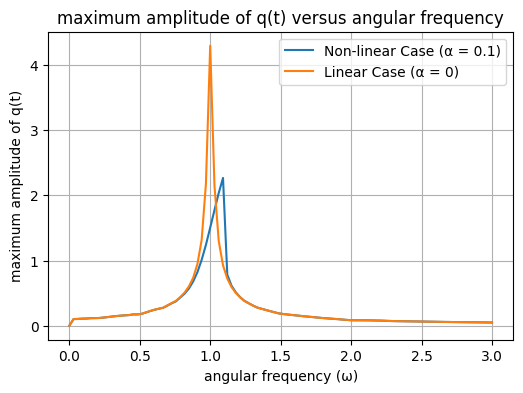

Maximum q value reached in the non-linear case (α != 0): 2.27 at ω = 1.09
Maximum q value reached in the linear case (α = 0): 4.30 at ω = 1.00


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Constants
omega0 = 1.0  # Natural frequency
xi = 0.01     # Damping factor
alphaa = 0.1   # Non-linearity parameter
A = 0.1       # Amplitude of the external force for fair comparison

# Function that defines the differential equation for the non-linear case
def nonlinear_diffeq(y, t, omega):
    q, q_dot = y
    q_ddot = (1 / omega0**2) * (-2 * xi * q_dot - q - alphaa * q**3 + A * np.sin(omega*t))
    return [q_dot, q_ddot]

# Range of omega values
omega_values = np.linspace(0, 3 * omega0, 100)  # Adjust the number of points as needed

# Initialize array to store maximum amplitudes for non-linear case
max_amp_nonlin = []

# Simulate and calculate maximum amplitudes for different omega values (non-linear case)
for omega in omega_values:
    # Initial conditions
    y0 = [0.0, 0.0]  # Initial values for q and q'
    # Time points for the solution
    t = np.linspace(0, 200, 1000)  # Adjust the time range as needed

    # Solve the differential equation for the non-linear case
    solution = odeint(nonlinear_diffeq, y0, t, args=(omega,))

    # Extract q values from the solution
    q = solution[:, 0]

    # Calculate maximum amplitude of q(t)
    max_amp = np.max(np.abs(q))
    max_amp_nonlin.append(max_amp)

# Constants for the linear case (alpha = 0)
Max_amp_lin = []

# Simulate and calculate maximum amplitudes for different omega values (linear case)
for omega in omega_values:
    # Linear differential equation (alpha = 0)
    def linear_diffeq(y, t):
        q, q_dot = y
        q_ddot = -2.0 * xi * omega0 * q_dot - omega0**2 * q + A * np.sin(omega * t)
        return [q_dot, q_ddot]

    # Solve the differential equation for the linear case
    sol_linear = odeint(linear_diffeq, y0, t)

    # Extract charge (q) values for the linear case
    q_linear = sol_linear[:, 0]

    # Calculate maximum amplitude of q(t) for the linear case
    max_amp = np.max(np.abs(q_linear))
    Max_amp_lin.append(max_amp)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(omega_values, max_amp_nonlin, label='Non-linear Case (α = 0.1)')
plt.plot(omega_values, Max_amp_lin, label='Linear Case (α = 0)')
plt.xlabel('angular frequency (ω)')
plt.ylabel('maximum amplitude of q(t)')
plt.title('(5) maximum amplitude of q(t) versus angular frequency')
plt.legend()
plt.grid(True)
plt.show()

# Find the maximum amplitude and corresponding omega for the non-linear case
Max_amp_nonlin = np.max(max_amp_nonlin)
Max_amp_nonlin_index = np.argmax(max_amp_nonlin)
omega_max_nonlin_index = omega_values[Max_amp_nonlin_index]

# Find the maximum amplitude and corresponding omega for the linear case
max_amp_lin = np.max(Max_amp_lin)
max_amp_lin_index = np.argmax(Max_amp_lin)
omega_max_amp_lin = omega_values[max_amp_lin_index]

# Print out the maximum q value reached and corresponding omega for both cases
print(f"Maximum q value reached in the nonlinear case (α != 0): {Max_amp_nonlin:.2f} at ω = {omega_max_nonlin_index:.2f}")
print(f"Maximum q value reached in the linear case (α = 0): {max_amp_lin:.2f} at ω = {omega_max_amp_lin:.2f}")


The differences between the linear case (α = 0) and the nonlinear case (α != 0) can be clearly seen in graph (5) --> The linear case where we (α = 0) shows a much larger peak at q = 4.30 (at $ \omega$ = 1.00) than the case where (α != 0), there we get a value of q = 2.27 (at $ \omega$ = 1.09).

So yes, we can indeed clearly see the effect that nonlinearity has on our system. --> it effectively shrinks the value for the charge, q.